# Finding features of our PSD

In [1]:
# loading the packages
import numpy as np
# import mne
from tqdm import tqdm
# from tqdm import tqdm
import skfda
import pandas as pd
# import os
# import matplotlib.pyplot as plt
# from skfda.exploratory.visualization import Boxplot
from skfda.inference.anova import oneway_anova
import scipy
import os

import matplotlib.pyplot as plt


In [2]:
# selezionare banda di frequenza
banda=str(1)

# selzione del canale che stiamo studiando
i = 1
canale = str(i)

In [3]:
home_path = os.path.abspath(os.getcwd())
home_path

'C:\\Users\\Asus\\OneDrive\\Desktop\\NL2\\FDAxEEG\\Dataset'

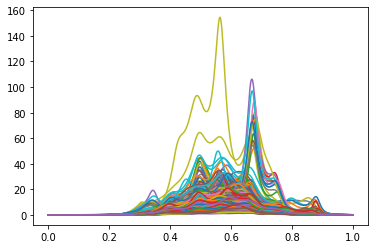

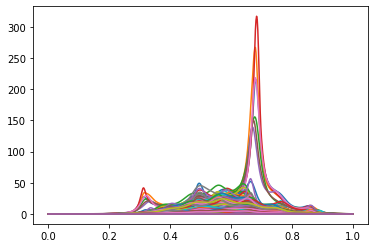

In [4]:
# loading the data of ADHD
filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+canale+"_p"+banda
mat = scipy.io.loadmat(filename_adhd)
PSD_ADHD=mat['avg']
df_Channel=pd.DataFrame(data=PSD_ADHD)
Channel=df_Channel.to_numpy(dtype=None, copy=False)
Channel = np.nan_to_num(Channel)
ADHD=skfda.FDataGrid(data_matrix=Channel)
ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

# loading the data of control
filename_control = home_path+"\Control_Matrici_medie\zona"+canale+"_p"+banda
mat = scipy.io.loadmat(filename_control)
PSD_control=mat['avg']
df_Channel=pd.DataFrame(data=PSD_control)
Channel=df_Channel.to_numpy(dtype=None, copy=False)
Channel = np.nan_to_num(Channel)
Control=skfda.FDataGrid(data_matrix=Channel)
Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

plot_adhd = ADHD.plot()
plot_control = Control.plot()

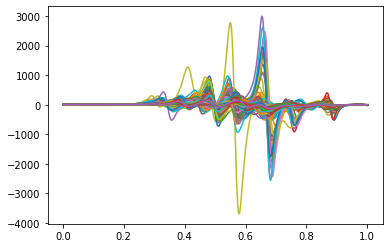

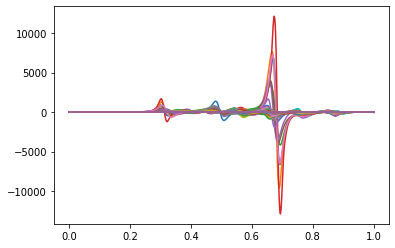

In [5]:
# computing the derivatives of the curves
ADHD_der=ADHD.derivative()
Control_der=Control.derivative()

plot_adhd_der = ADHD_der.plot()
plot_control_der = Control_der.plot()
    

### Computing the intergral of the absolute value of the first derivative
$$ I = \int \|f'(t)\| dt $$

Median: 24.187641869531944
Mean: 33.97126106604104
Starndard deviation: 33.59599897683493


{'whiskers': [<matplotlib.lines.Line2D at 0x1f261e8fc10>,
 'caps': [<matplotlib.lines.Line2D at 0x1f261ead1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f261e8f970>],
 'medians': [<matplotlib.lines.Line2D at 0x1f261ead790>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f261eada60>],
 'means': []}

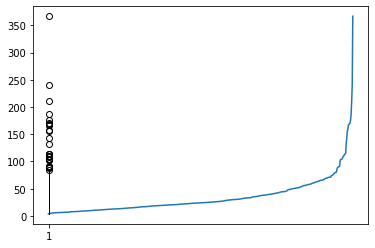

In [6]:
# integral of the derivative of the adhd group
ADHD_der_abs = ADHD_der
ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

n_adhd = ADHD_der_abs.data_matrix.shape[0]

int_adhd = np.empty(n_adhd)
for i in range(n_adhd):
    int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])

plt.plot(np.sort(int_adhd))
print("Median: "+str(np.median(int_adhd)))
print("Mean: "+str(np.mean(int_adhd)))
print("Starndard deviation: "+str(np.std(int_adhd)))

plt.boxplot(int_adhd)

Median: 19.384408047136578
Mean: 28.729112039574048
Starndard deviation: 53.39873121820436


{'whiskers': [<matplotlib.lines.Line2D at 0x1f261f0f9a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f261f0ff40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f261f0f700>],
 'medians': [<matplotlib.lines.Line2D at 0x1f261f1a520>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f261f1a7f0>],
 'means': []}

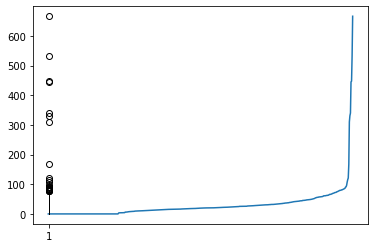

In [7]:
# integral of the derivative of the control group
Control_der_abs = Control_der
Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

n_cont = Control_der_abs.data_matrix.shape[0]

int_cont = np.empty(n_cont)
for i in range(n_cont):
    int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])

plt.plot(np.sort(int_cont))
print("Median: "+str(np.median(int_cont)))
print("Mean: "+str(np.mean(int_cont)))
print("Starndard deviation: "+str(np.std(int_cont)))

plt.boxplot(int_cont)


### Anova on the integrals

In [8]:
aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

ANOVA results: 
F statistics: 	3.8250119845634494
p_value: 	0.05074400806315549


### Same study extended to all the zones and frequential bands

In [9]:
# funzione per calcolare integrali delle derivate e fare anova tra i due gruppi

def AnovaIntDer(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # compute the derivatives of the functions
    ADHD_der=ADHD.derivative()
    Control_der=Control.derivative()

    # integral of the derivative of the adhd group
    ADHD_der_abs = ADHD_der
    ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

    n_adhd = ADHD_der_abs.data_matrix.shape[0]

    int_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])
        
    # print("ADHD:")
    # print("Median: "+str(np.median(int_adhd)))
    # print("Mean: "+str(np.mean(int_adhd)))
    # print("Starndard deviation: "+str(np.std(int_adhd)))

    # integral of the derivative of the control group
    Control_der_abs = Control_der
    Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

    n_cont = Control_der_abs.data_matrix.shape[0]

    int_cont = np.empty(n_cont)
    for i in range(n_cont):
        int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])

    # print("Control:")
    # print("Median: "+str(np.median(int_cont)))
    # print("Mean: "+str(np.mean(int_cont)))
    # print("Starndard deviation: "+str(np.std(int_cont)))

    # ANOVA

    aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    return aov.pvalue


In [10]:
p_val = np.empty((7,5))
p_val.shape

(7, 5)

In [11]:
for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaIntDer(canale, banda, home_path)   
    

In [12]:
print(pd.DataFrame(p_val))

          0             1         2         3         4
0  0.050744  9.367398e-02  0.001473  0.000007  0.441347
1  0.022469  1.991935e-02  0.000101  0.000008  0.880253
2  0.766977  2.799901e-01  0.063040  0.056519  0.607765
3  0.679961  7.206853e-01  0.704220  0.036276  0.013073
4  0.164088  1.414674e-01  0.057432  0.133727  0.037508
5  0.074298  5.238896e-01  0.847368  0.879055  0.058115
6  0.000004  3.351522e-07  0.002032  0.014414  0.196780


## $L^2$ norm study

In [13]:
# funzione per calcolare norma L2 e fare anova tra i due gruppi

def AnovaNormLp(canale, banda, home_path, order=2):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # L2 norm of ADHD group
    n_adhd = ADHD.data_matrix.shape[0]

    norm_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        norm_adhd[i]=np.linalg.norm(ADHD.data_matrix[i], ord = order)

    # L2 norm of control group
    n_cont = Control.data_matrix.shape[0]

    norm_cont = np.empty(n_cont)
    for i in range(n_cont):
        norm_cont[i]=np.linalg.norm(Control.data_matrix[i], ord = order)

    # ANOVA

    aov = scipy.stats.f_oneway(norm_adhd,norm_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    return aov.pvalue


In [14]:
p_val_norm = np.empty((7,5))

for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaNormLp(canale, banda, home_path)

print(pd.DataFrame(p_val))

              0             1         2         3         4
0  1.760714e-04  6.484130e-03  0.000952  0.000005  0.268375
1  2.272964e-05  1.506436e-03  0.000097  0.000003  0.937976
2  1.282320e-01  5.006179e-02  0.126745  0.103027  0.774620
3  4.438451e-01  4.441835e-01  0.929130  0.028178  0.009000
4  1.061268e-02  1.097429e-01  0.095706  0.143365  0.039019
5  7.006290e-01  9.678763e-01  0.766097  0.822584  0.056914
6  5.422379e-07  3.197499e-07  0.002664  0.007183  0.470215


In [15]:
# funzione per calcolare picchi fare anova tra i due gruppi

def AnovaPicco(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    Picco_ADHD=ADHD.data_matrix.max(1)
        
    # print("ADHD:")
    # print("Median: "+str(np.median(Picco_ADHD)))
    # print("Mean: "+str(np.mean(Picco_ADHD)))
    # print("Starndard deviation: "+str(np.std(Picco_ADHD)))

    Picco_Control=Control.data_matrix.max(1)

    # print("Control:")
    # print("Median: "+str(np.median(Picco_Control)))
    # print("Mean: "+str(np.mean(Picco_Control)))
    # print("Starndard deviation: "+str(np.std(Picco_Control)))

    # ANOVA

    aov = scipy.stats.f_oneway(Picco_ADHD, Picco_Control)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    return aov.pvalue


In [16]:
p_val_picco = np.empty((7,5))

for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaPicco(canale, banda, home_path)

print(pd.DataFrame(p_val))

              0             1         2         3         4
0  5.794673e-02  2.798019e-01  0.006598  0.000009  0.820459
1  4.348068e-02  6.620015e-02  0.000305  0.000008  0.454999
2  8.807232e-01  2.043876e-01  0.380061  0.052227  0.382565
3  5.335823e-01  6.976710e-01  0.792416  0.027011  0.011381
4  2.041361e-01  3.835220e-01  0.140667  0.074066  0.034234
5  1.082229e-01  5.073217e-01  0.482967  0.374911  0.045611
6  8.980203e-07  7.700539e-08  0.007337  0.001445  0.097208
